In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_theme()

# https://www.kaggle.com/datasets/beatafaron/fmcg-daily-sales-data-to-2022-2024

In [2]:
def read_data():
    data = pd.read_csv(r"C:\Users\flori\Documents\Github\Forecasting\data\FMCG_2022_2024.csv")
    return data

data = read_data()

# 1 Data Engineering

In [4]:
# Convert date into datetime and set as index
def convert_date(df):

    # Convert into datetime
    df["date"] = pd.to_datetime(df["date"])

    # Set as index
    df = df.set_index("date")

    # Restrict Date Range
    '''
    Some categories start later than others. Therefore the data range will be 
    restricted to the date where all categories have data.
    '''
    df = df[(df.index >= "2022-09-10") & (df.index <= "2024-12-31")]

    return df

data = convert_date(data)

In [5]:
def data_aggregating(data):

    # Sicherstellen, dass der Index ein DatetimeIndex ist
    data = data.copy()
    
    # DataFrame mit allen Tagen
    df_join = pd.DataFrame(index=pd.date_range(data.index.min(), data.index.max()))
    
    # Gesamtanzahl Transaktionen pro Tag
    sum_units_sold = data.resample("D")["units_sold"].sum()
    df_join = df_join.join(sum_units_sold.rename("Sum_units_sold"))
    
    # Kategoriale Spalten
    cat_cols = ["region", "channel", "pack_type", "promotion_flag"]
    for col in cat_cols:
        for cat in data[col].unique():
            count_cat = data[data[col] == cat].resample("D")[col].count().rename(f"Abs_{col}_{cat}")
            prop_cat = (count_cat / data.resample("D")["units_sold"].count()).rename(f"Prop_{col}_{cat}")
            # df_join = df_join.join(count_cat)
            df_join = df_join.join(prop_cat)
    

    # Numerische Spalten
    num_cols = ["price_unit", "delivery_days", "stock_available", "delivered_qty"]
    for col in num_cols:
        if col == "price_unit":
            mean_col = data.resample("D")[col].mean().rename(f"Mean_{col}")
            df_join = df_join.join(mean_col)
        else:
            sum_col = data.resample("D")[col].sum().rename(f"Sum_{col}")
            df_join = df_join.join(sum_col)
    
    return df_join

df_ml = data_aggregating(data)


In [6]:
def feature_enrichment(df):

    df = df_ml.copy()

    # Time Features
    df["Year"] = df.index.year
    df["Quarter"] = df.index.quarter
    df["Month"] = df.index.month
    df["Day"] = df.index.day
    df["DayOfWeek"] = df.index.dayofweek

    # Lag Features
    df["Lag_1"] = df["Sum_units_sold"].shift(1, fill_value = 0)
    df["Lag_7"] = df["Sum_units_sold"].shift(7, fill_value = 0)
    df["Lag_30"] = df["Sum_units_sold"].shift(30, fill_value = 0)
    df["Lag_90"] = df["Sum_units_sold"].shift(90, fill_value = 0)
    df["Lag_365"] = df["Sum_units_sold"].shift(365, fill_value = 0)
    df["Lag_730"] = df["Sum_units_sold"].shift(365*2, fill_value = 0)

    df = df.dropna()

    return df

df_ml = feature_enrichment(df_ml)

# 2 XGBoost Regression

In [8]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

In [9]:
def data_split(df):
    ''' 
    1 week will be hold back for testing with the final model found in the cross validation
    '''
    df = df_ml.sort_index()
    date_split = df.index.max() - pd.DateOffset(weeks=1)
    
    train_data = df[df.index <= date_split]
    test_data  = df[df.index > date_split]
    
    X = train_data.drop(columns="Sum_units_sold")
    y = train_data["Sum_units_sold"]
    
    return train_data, test_data, X, y

train_data, test_data, X, y = data_split(df_ml)

## 2.1 Fit and Predict with Best Model

In [10]:
X_train = X
y_train = y
X_test = test_data.drop(columns="Sum_units_sold")
y_test = test_data["Sum_units_sold"]

# Final XGB Model
reg_final = XGBRegressor(
    n_estimators=2000,
    random_state=42,
    max_depth=3,
    learning_rate=0.01,
    n_jobs=-1
)

# Final Fit
reg_final.fit(X_train, y_train)

# Predict
y_pred = reg_final.predict(X_test)

In [11]:
# Final RMSE Score
rmse_score_final = root_mean_squared_error(y_test, y_pred)
print("Final RMSE Score",rmse_score_final)

Final RMSE Score 85.16361999511719


In [12]:
final_model_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}, index=y_test.index)

fig = px.line(data_frame=final_model_df, 
              x=final_model_df.index, 
              y=["Prediction", "Actual"],
              title=f"Final Model Prediction vs Actual (RMSE Score: {rmse_score_final:.4f})",
              markers=True
              )
fig.show()

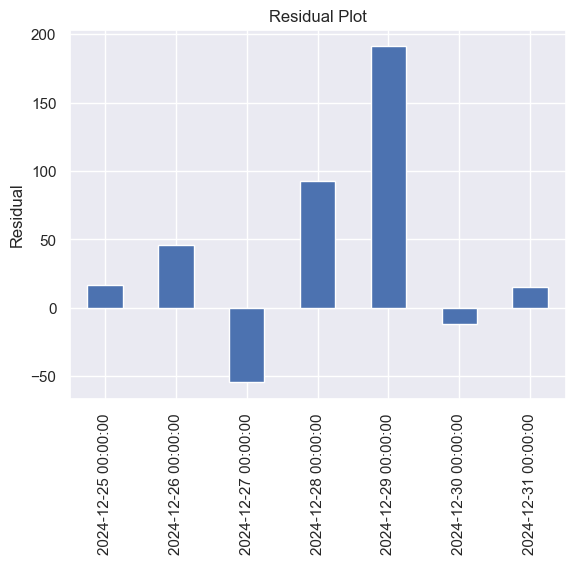

In [55]:
final_model_df["Residuals"] = final_model_df["Prediction"] - final_model_df["Actual"]
final_model_df["Residuals"].plot(kind="bar", title="Residual Plot", ylabel="Residual");

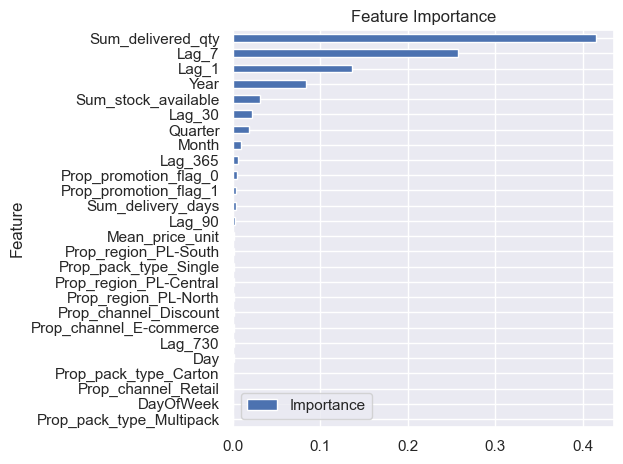

In [49]:
feature = reg_final.feature_names_in_
importance = reg_final.feature_importances_

feature_importance_df = pd.DataFrame({"Feature": feature, "Importance": importance})
feature_importance_df = feature_importance_df.set_index("Feature")

feature_importance_df.sort_values(by="Importance").plot(kind="barh")
plt.title("Feature Importance")
plt.tight_layout();